<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Cost-vs-qubits-size" data-toc-modified-id="Cost-vs-qubits-size-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Cost vs qubits size</a></span></li></ul></div>

In [2]:
import numpy as np
import networkx as nx
from loguru import logger as log
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import copy
import sys
sys.path.append('..')
sns.set_style('whitegrid')
import qtree 
import utils
import utils_qaoa as qaoa
import utils_mproc as mputils

%load_ext autoreload
%autoreload 2

ModuleNotFoundError("No module named 'tensorflow'")


## Cost vs qubits size 

In [36]:
def log_log_scale():
    plt.yscale('log')
    plt.xscale('log')
    
def minorticks():
    plt.minorticks_on()
    plt.grid(which='minor', alpha=0.3, linestyle='-', axis='both')
    
def get_est(xs, vals):
    mem_est = np.polyfit(xs, np.log(vals), 2)
    mem_est = np.poly1d(mem_est)
    est = np.linspace(20,2e2, 100)
    mem_est = mem_est(est)
    return est,  np.exp(mem_est)

In [15]:
sizes = np.arange(13,54,2)
results = [
   qaoa.get_cost_of_task(s, 1, type='randomreg',degree=3) for s in sizes
]

100%|██████████| 1566/1566 [00:38<00:00, 40.88it/s] 


In [16]:
def plot_theory(results, ns):
    
    sums = [(max(y[0]), sum(y[1])) for y in results]
    colors = [plt.cm.gnuplot2(x) for x in np.linspace(.8,.2,2)]
    memsums, flopsums = zip(*sums)

    est, mem_est = get_est(ns, memsums)
    est, flop_est = get_est(ns, flopsums)


    plt.plot(ns, flopsums, label='total FLOP', color=colors[1])
    plt.plot(ns, np.array(memsums), label='maximum Memory', color=colors[0])
    #plt.plot(est, mem_est, '--', label='mem log-log fit')
    #plt.plot(est, flop_est, '--', label='flop log-log fit')

    plt.xlabel('Number of qbits')
    plt.yscale('log')
    #plt.xscale('log')
    #plt.suptitle('QAOA one amplitude simulation cost', fontsize=14)
    #plt.title('MaxCut random regular graphs')
    plt.legend()
    plt.minorticks_on()
    plt.grid(which='minor', alpha=0.3, linestyle='-', axis='both')
    #ax = plt.gca().twinx()
    #plt.grid(None)
    #plt.plot(ns, nghssums, label='max ng', color='red')

In [17]:
import glob
import json

thread_folders = sorted(glob.glob('./contract_data/contr_profile_*thr'))
print(thread_folders)
thread_files = [sorted(glob.glob(folder+'/*.json')) for folder in thread_folders]
print(list(map(len, thread_files)))
thread_exps = [[json.load(open(f)) for f in files] for files in thread_files]
exp_results = [
    (max(e['proc_buck memory'])
    ,1e9*np.array(e['proc_buck time']).sum()
    )
    for exps in thread_exps
    for e in exps
]
print(len(exp_results))
sizes_exp = range(13,49,2)
threads_exp = [1, 16]
exp_results = np.array(exp_results).reshape(len(thread_exps), len(sizes_exp), 2)
print(exp_results.shape)

ns = list(zip(*results))[3]

['./contract_data/contr_profile_16thr', './contract_data/contr_profile_1thr']
[18, 18]
36
(2, 18, 2)


(18,)


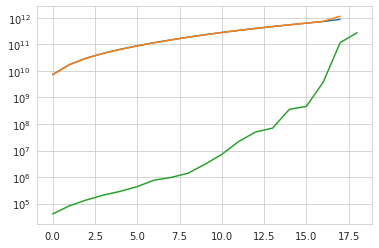

In [18]:
#plot_theory(results, ns)
print(exp_results[0,:,1].shape)
plt.plot( exp_results[0,:,1])
plt.plot( exp_results[1,:,1])
result_rows = list(zip(*results))
plt.plot( list(map(sum, result_rows[1]))[:-2])

plt.yscale('log')
plt.savefig('figures/cost_vs_taskS_42d3.pdf')


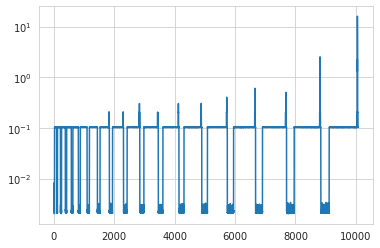

In [19]:
plt.plot(thread_exps[0][-1]['proc_buck time'])
plt.yscale('log')


In [20]:
total_data = json.load(open('./contract_data/contr_profile_total_13_49_2_42d3.json'))
sim_sum = total_data['Total_sim']

In [21]:
new_data = json.load(open('./contract_data/contr_profile_data47_42d3.json'))
single_threaded_time = new_data['proc_buck time']
single_threaded_mem = new_data['proc_buck memory']

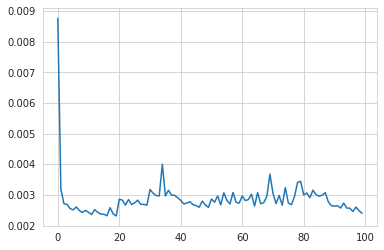

In [22]:
list(sizes_exp)
plt.plot(single_threaded_time[:100])
#plt.yscale('log')

[7.31225872e+09 1.02439237e+10 1.31401970e+10 1.60871885e+10
 1.90075171e+10 2.34197588e+10 2.78129215e+10 3.23914726e+10
 3.84730556e+10 4.48279376e+10 5.05434315e+10 5.68319888e+10
 6.29880102e+10 7.05494864e+10 7.86340532e+10 8.60132837e+10
 9.90100219e+10 1.48003854e+11]
(2, 18)


Text(0.5, 0, 'Number of qubits')

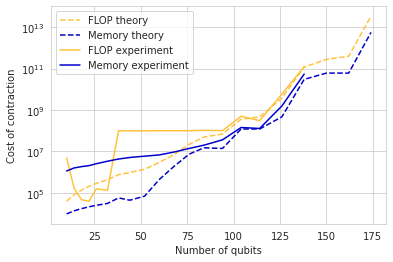

In [40]:
colors = [plt.cm.gnuplot2(x) for x in np.linspace(.8,.2,2)]
lens = [len(x) for x in result_rows[0]]

def unpack_flops(all_flops, map_f=sum):
    flops = []
    for i, s in enumerate(sizes_exp):
        prev = i
        end = i+1
        prev, end = [sum(lens[:x]) for x in (prev, end)]
        flops.append(all_flops[prev:end])
    sums_flops = [map_f(x) for x in flops]
    return sums_flops

sums_flops = [ unpack_flops(thread_exps[i][-1]['proc_buck time']) 
             for i in range(len(thread_exps)) ]

sums_flops = 1e9*np.array(sums_flops)
print(sums_flops[0])
print(sums_flops.shape)
sums_flops_theory = [sum(x) for x in result_rows[1]]
sums_mems_theory = [max(x) for x in result_rows[0]]
#for sf in sums_flops: plt.plot(sf)

plt.plot(ns, sums_flops_theory, '--'
         , color=colors[0]
         , label='FLOP theory'
        )
plt.plot(ns, 16*np.array(sums_mems_theory), '--' 
         , color=colors[1]
         , label='Memory theory'
        )

unp_flop = 1e9*np.array(unpack_flops(single_threaded_time, map_f=max))
unp_mem = unpack_flops(single_threaded_mem, map_f=max)


ns_exp = ns[:len(unp_mem)]

min_shift = lambda x: np.array(x) - .99*min(x)
flop_mem_shifted = (min_shift(x) for x in (unp_flop, unp_mem))

plt.plot(ns_exp, next(flop_mem_shifted), '-'
         , color=colors[0]
         , label='FLOP experiment'
        )
plt.plot(ns_exp, next(flop_mem_shifted), '-'
         , color=colors[1]
         , label='Memory experiment'
        )
plt.legend()
plt.yscale('log')
plt.minorticks_on()
plt.ylabel('Cost of contraction')
plt.xlabel('Number of qubits')
plt.savefig('figures/theory_vs_exp_tasks_')
    